# pyCFI Validation Notebook - Improved Approach - Brodland 2017 Data

### Notes

- Open issues are marked in comments using the word `FLAG`


- Validation-specific open issues are marked in comments using the word `VALFLAG`


- ***TO BE INVESTIGATED:***
    - First port any relevant improvements from `VAL_Brodland`**[done]**
        - *Positive side note: on t9 it actually doesn't work too badly!*
    - Look into why the DN projections are often very bad ***[YAH!]***
        - Problem identified (I think): the TN is often 'off' from the actual center point of the junction
        - This is because the TN is taken from the spline, which can be shifted compared to the real data
        - The spline should thus only be used for projection, not to provide TNs for fitting
        - Two options to pursue to fix this:
            - 'Dirty': During fitting, use the point closest to spl-TN (instead of spl-TN itself) when a TN point is needed
            - 'Clean': Use the spline fits really only for getting the plane, then use real TN points
                - This limits the `Improved` approach to existing TN points in planes (not ideal?)
                - This may cause trouble with multiple TN points per plane (esp. in the `Brodland` approach) 
    - There is a RuntimeWarning in the arc fitting that I haven't seen anywhere else before
        - `RuntimeWarning: Number of calls to function has reached maxfev = 600.`
    - There are *a lot* of inscribed circles
        - Check the reason why and whether the centroid fix is appropriate
    - The fitted vectors often seem a bit off somehow... **[important?!]**
        - This may also be the case in `VAL_Brodland`!
        - Is the TN position during arc fitting a bit off from the other points?
            - But how could this here be the case? In the projection, the TN should after all just be at `0`, right?
            - If this is the case, see how to fix it and whether that improves the fitted vectors
        - If this isn't easily fixed, do all the "up porting" to DEV and double-check with the "simple" data
            - Are the vectors also often a little off here? If so, how to fix it? If not, what is different in VAL?
        

- ***TO BE PORTED UP:***
    - Add the `min_DNs` constraint
    - Wherever DJ_IDs are generated by `itertools.combinations` of TJ_IDs, skip those DJ_IDs that have been removed!
    - Correct `<= min_TNs` to `< min_TNs` where necessary
    - Add `figsize=(4,4)` and `plt.{x|y}lim([-1.1, 1.1])` to all three vector plotting loops
    - Adjust the query range for finding TN-adjacent points during arc fitting to the resolution!
    - Convert TJs and DJs defaultdicts to dicts and add appropriate handling
    - Projection: Removal of TNs where only very few or only very closely bunched up neighbors are found during arc fitting
        - **[requires review]** This may not be necessary here in `VAL_Improved`!
    - Arc fitting: Removal of TNs where the arc fitting erroneously produces an "inscribed" circle
    - Arc fitting: Get rid of the overly specific straight line fix
    - Improve the TJ spline visualization to keep the same colors as in the previous 3D plot
    - More angle wrapping issues:
        - Copy over the `wrap_median` function
        - Use it instead of `np.median` wherever appropriate (and change name from `median` to `median_ang`)
        - Use `wrap_sub` for initial zeroing during triplet alignment
    - Add comments to parameters/settings
    - Add the new consensus calculation and the max deviation treshold
    - Add dropping of columns from `G` (whilst handling relevant 'linked' objects)!
    - During CellFIT data loading, add selector of `t4` vs `t9` based on `fpath`
    - Add the `nan` fill-in before arc fitting and then add the nan-removal cell afterwards
    
    
- ***TO BE PORTED:***
    - ...

### Prep

In [1]:
### Imports

import itertools, collections
import warnings

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from skimage import io
from scipy import spatial
from scipy import interpolate
from scipy import optimize
import sympy as sym

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

In [2]:
### Parameters & Settings

#fpath   = r'..\Data\Brodland\brodland_20190726_clean\t000004\t000004_processed_segmented.tif'
fpath   = r'..\Data\Brodland\brodland_20190726_clean\t000009\t000009_processed_segmented.tif'
res     = np.array([1.0, 0.25, 0.25])  # Voxel sizes (z,y,x) in microns  # VALFLAG: ESTIMATED! ASK JIM VELDHUIS!
min_TNs =   3  # Min TNs detected in the stack for a given TJ (TJ eliminated otherwise)
min_DNs = 500  # Min DNs detected in the stack for a given DJ (DJ eliminated otherwise)
min_z   =   3  # Min number of z slices a TJ or DJ must occur in (TJ or DJ eliminated otherwise)
t_cons  =  10  # Max allowed mean vector deviation from consensus [in % of unit circle](TJ elimiated otherwise)

In [3]:
### Load input segmentation stack

im = io.imread(fpath) - 1 # VALFLAG: They had the background set to 1!
print(im.dtype, im.shape)

uint16 (30, 512, 512)


In [4]:
### Show input stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(im[z], cmap='gray', vmin=im.min(), vmax=im.max())
    plt.show()

interactive(children=(IntSlider(value=15, description='z', max=29), Output()), _dom_classes=('widget-interact'…

### VALFLAG: Some Image Preprocessing to Improve the Low Quality Validation Data!

In [5]:
### VALFLAG: Use morphological filters to smoothen the segmentation outlines 

from scipy.ndimage import grey_dilation, grey_erosion

num_iters = 10
im2 = np.copy(im)

d = 9  # VALFLAG: param
struct = (np.mgrid[:d,:d][0] - np.floor(d/2))**2 + (np.mgrid[:d,:d][1] - np.floor(d/2))**2 <= np.floor(d/2)**2
struct3D = np.zeros((3, d, d), dtype=np.bool)
struct3D[1, :, :] = struct

for i in range(num_iters):
    im2 = grey_dilation(im2, footprint=struct3D)
    im2 = grey_erosion(im2, footprint=struct3D)
    im2 = grey_erosion(im2, footprint=struct3D)
    im2 = grey_dilation(im2, footprint=struct3D)

im = im2
print(im.dtype, im.shape)

uint16 (30, 512, 512)


In [6]:
### VALFLAG: Show improved input stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(im[z], cmap='gray', vmin=im.min(), vmax=im.max())
    plt.show()

interactive(children=(IntSlider(value=15, description='z', max=29), Output()), _dom_classes=('widget-interact'…

In [7]:
### VALFLAG: Use interpolation to increase the number of z-slices

# VALFLAG -- PRECISION: The currently employed majority interpolation works fine in
#                       some geometries (those defined by 2D aspects)but generates 
#                       unnatural 'ridges' in others (where 3D matters more)!

# VALFLAG -- STABILITY: Since skimage.filters.rank.windowed_histogram works only on
#                       uint8 data (gives nonsense results on uint16!), this only
#                       works if images/segmentations where typecasting to uint8
#                       is safe (i.e. no object IDs outside of the uint8 range)!
if not im.dtype == np.uint8:
    warnings.warn('\n`im.dtype` is not `np.uint8` and will be typecast "blindly"!'+
                  '\nAny object IDs outside of the uint8 range will wrap!')

# Get tool
from skimage.filters.rank import windowed_histogram

# Generate structural element
d = 20  # VALFLAG: param
struct = (np.mgrid[:d,:d][0] - np.floor(d/2))**2 + (np.mgrid[:d,:d][1] - np.floor(d/2))**2 <= np.floor(d/2)**2

# Get number of bins to use
n_bins = im.max() + 1

# Interpolation function
def seg_interp(im):
    
    # Prepare output array
    imi = np.zeros((im.shape[0]*2-1, im.shape[1], im.shape[2]), dtype=np.uint8)
    
    # For each slice
    for s in range(im.shape[0]-1):
        
        # Count the prevalence of each object in its neighborhood
        s_hist  = windowed_histogram(im[s,:,:].astype(np.uint8),   struct, n_bins=n_bins)
        s_hist += windowed_histogram(im[s+1,:,:].astype(np.uint8), struct, n_bins=n_bins)
        
        # Check if the result makes sense
        if not np.allclose(s_hist.sum(), 2.0*im[0].size) and not np.allclose(s_hist.sum(), 0.0):
            raise Exception("`s_hist` is not consistent with expectations!")
        
        # Fill the pixels based on the majority object in the neighborhood
        imi[s*2+1] = np.argmax(s_hist, axis=-1)
    
    # Fill the other slices with the original image
    imi[::2] = im
    
    # Done
    return imi

# Run it
im = seg_interp(im)

# Adjust the resolution
res[0] = res[0] / 2.0

C:\Users\Jonas Hartmann\Anaconda\envs\py3base\lib\site-packages\ipykernel\__main__.py:13: UserWarning: 
`im.dtype` is not `np.uint8` and will be typecast "blindly"!
Any object IDs outside of the uint8 range will wrap!


In [8]:
### VALFLAG: Show improved input stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(im[z], cmap='gray', vmin=im.min(), vmax=im.max())
    plt.show()

interactive(children=(IntSlider(value=29, description='z', max=58), Output()), _dom_classes=('widget-interact'…

### Identifying Object Outlines

In [9]:
### Identify outline voxels by comparing shifted images

# Pad the image by 1 voxel on all sides
im_pad = np.pad(im, 1, mode='reflect')

# Get possible shifts in all directions
shifts = itertools.product([0,1], repeat=3)

# Check and accumulate differences in shifts
outlines = np.zeros_like(im, dtype=np.bool)
for shift in shifts:
    zs0, ys0, xs0 = [slice(1, None) if s else slice(None) for s in shift]
    zs1, ys1, xs1 = [slice(None,-1) if s else slice(None) for s in shift]
    comparison = im_pad[zs0, ys0, xs0] != im_pad[zs1, ys1, xs1]
    outlines  += comparison[:im.shape[0],  :im.shape[1],  :im.shape[2]]
    outlines  += comparison[-im.shape[0]:, -im.shape[1]:, -im.shape[2]:]  # Symmetry
    
# Re-annotate the cell identities
outlines_id = outlines * im

# Report
print(outlines.dtype, outlines.shape)
print(outlines_id.dtype, outlines_id.shape)

bool (59, 512, 512)
uint8 (59, 512, 512)


In [10]:
### Show identified outlines

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray', vmin=outlines_id.min(), vmax=outlines_id.max())
    plt.show()

interactive(children=(IntSlider(value=29, description='z', max=58), Output()), _dom_classes=('widget-interact'…

### Identifying Triple Nodes (TNs) and Triple Junctions (TJs)

In [11]:
### Find coordinates of all voxels involved in triple junctions

# FLAG: PERFORMANCE -- This could potentially be done with image shifting much like `outlines` above!
# FLAG: PRECISION -- For the coordinates, would a `+1.0` be more appropriate at interfaces between two cells?

# Get Outline Indices (OIs) and Outline Coordinates (OCs)
OIs = np.array(np.where(outlines)).T
OCs = (OIs + 0.5) * res

# Go through OIs and find TN Indices (TNIs)
TNIs = []
for OI in OIs:
    selection = im_pad[OI[0]+1:OI[0]+3, OI[1]+1:OI[1]+3, OI[2]+1:OI[2]+3]
    if len(set(selection.flatten())) == 3:
        TNIs.append(OI)
TNIs = np.array(TNIs)

# Convert to TN Coordinates (TNCs)
TNCs = (TNIs + 0.5) * res

# Report
print('OCs: ', OCs.shape)
print('TNIs:', TNIs.shape)
print('TNCs:', TNCs.shape)

OCs:  (268091, 3)
TNIs: (3363, 3)
TNCs: (3363, 3)


In [12]:
### Build a dict of TJs structured as: {tuple(cell1_ID, cell2_ID, cell3_ID) : array(INDICES INTO TNIs/TNCs)}

# Prepare defaultdict
TJs = collections.defaultdict(lambda : [])

# Go through TNs, create IDs, assign coordinates to IDs
for idx,TNI in enumerate(TNIs):
    selection = im_pad[np.int(TNI[0])+1:np.int(TNI[0])+3, 
                       np.int(TNI[1])+1:np.int(TNI[1])+3, 
                       np.int(TNI[2])+1:np.int(TNI[2])+3]
    TJ_ID = tuple(sorted(set(selection.flatten())))
    TJs[TJ_ID].append(idx)

# Convert TJ lists to numpy arrays & remove unwanted
for TJ_ID in list(TJs.keys()):
    
    # Remove if too short
    if len(TJs[TJ_ID]) < min_TNs:
        del TJs[TJ_ID]
        continue
        
    # Remove if not across >min_Z z-slices
    if np.unique(TNIs[TJs[TJ_ID]][:,0]).size < min_z:
        del TJs[TJ_ID]
        continue
    
    # Convert to array
    TJs[TJ_ID] = np.array(TJs[TJ_ID])
    
# Convert to non-defaultdict to avoid unexpected behavior
TJs = dict(TJs)

# Report
print('TJs:', len(TJs))

TJs: 28


In [13]:
### Show identified TJs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray', vmin=outlines_id.min(), vmax=outlines_id.max())
    
    # For each TJ...
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        
        # Get the TJ's TNs in the selected z plane
        TNs_in_plane = TNIs[TJs[TJ_ID]][TNIs[TJs[TJ_ID]][:,0]==z]
        
        # Plot the points
        plt.scatter(TNs_in_plane[:, 2], TNs_in_plane[:, 1],
                    c=[TJ_num for _ in range(TNs_in_plane.shape[0])], # Coloring trick!
                    cmap='hsv', vmin=0, vmax=len(TJs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=29, description='z', max=58), Output()), _dom_classes=('widget-interact'…

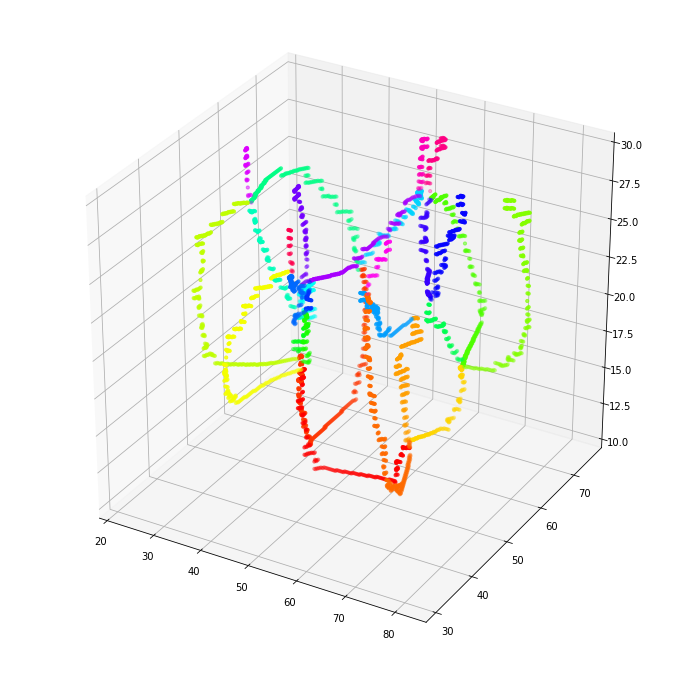

In [14]:
### Show identified TJs as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.scatter(TNCs[TJs[TJ_ID]][:,2], TNCs[TJs[TJ_ID]][:,1], TNCs[TJs[TJ_ID]][:,0],
               c=[TJ_num for _ in range(TJs[TJ_ID].shape[0])], 
               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

## Also show cell outlines [may take several seconds to render!]
#ax.scatter([c[2] for c in OCs],
#           [c[1] for c in OCs],
#           [c[0] for c in OCs],
#           c='gray', alpha=0.01, linewidth=0, s=5)

## Axis limits
#ax.set_xlim([0,200])
#ax.set_ylim([0,200])
#ax.set_zlim([0,200])

# Finish
plt.show()

### Identifying Double Nodes (DNs) and Double Junctions (DJs)

In [15]:
### Find coordinates of all voxels involved in DOUBLE junctions

# FLAG: PERFORMANCE -- Same as for TNI/TNC extraction above!
# FLAG: PRECISION -- Same as for TNI/TNC extraction above!

# Go through OIs and find DN Indices (DNIs)
DNIs = []
for OI in OIs:
    selection = im_pad[OI[0]+1:OI[0]+3, 
                       OI[1]+1:OI[1]+3, 
                       OI[2]+1:OI[2]+3]
    if len(set(selection.flatten())) == 2:
        DNIs.append(OI)
DNIs = np.array(DNIs)

# Convert to DN Coordinates (DNCs)
DNCs = (DNIs + 0.5) * res

# Report
print('OCs: ', OCs.shape)
print('DNIs:', DNIs.shape)
print('DNCs:', DNCs.shape)

OCs:  (268091, 3)
DNIs: (157601, 3)
DNCs: (157601, 3)


In [16]:
### Build a dict of Double Junctions (DJs) structured as: {tuple(cell1_ID, cell2_ID) : array(INDICES INTO DNIs/DNCs)}

# Prepare defaultdict
DJs = collections.defaultdict(lambda : [])

# Go through DNs, create IDs, assign coordinates to IDs
for idx,DNI in enumerate(DNIs):
    selection = im_pad[np.int(DNI[0])+1:np.int(DNI[0])+3, 
                       np.int(DNI[1])+1:np.int(DNI[1])+3, 
                       np.int(DNI[2])+1:np.int(DNI[2])+3]
    DJ_ID = tuple(sorted(set(selection.flatten())))
    DJs[DJ_ID].append(idx)

# Convert DJ lists to numpy arrays & remove unwanted
for DJ_ID in list(DJs.keys()):
    
    # Remove if too small
    if len(DJs[DJ_ID]) <= min_DNs:
        del DJs[DJ_ID]
        continue    
    
    # Remove if not across >min_z z-slices
    if np.unique(DNIs[DJs[DJ_ID]][:,0]).size < min_z:
        del DJs[DJ_ID]
        continue
    
    # Convert to array
    DJs[DJ_ID] = np.array(DJs[DJ_ID])
    
# Convert to non-defaultdict to avoid unexpected behavior
DJs = dict(DJs)

In [17]:
### Show identified DJs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray', vmin=outlines_id.min(), vmax=outlines_id.max())
    
    # For each DJ...
    for DJ_num,DJ_ID in enumerate(DJs.keys()):
        
        # Get the DJ's DNs in the selected z plane
        DNs_in_plane = DNIs[DJs[DJ_ID]][DNIs[DJs[DJ_ID]][:,0]==z]
        
        # Plot the points
        plt.scatter(DNs_in_plane[:, 2], DNs_in_plane[:, 1],
                    c=[DJ_num for _ in range(DNs_in_plane.shape[0])], # Coloring trick!
                    cmap='hsv', vmin=0, vmax=len(DJs), s=5, lw=0, alpha=0.5)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=29, description='z', max=58), Output()), _dom_classes=('widget-interact'…

### Fitting Splines to TJs

Turns out spline fitting requires the input points to be roughly in order along the spline, which isn't guaranteed in our case. Ordering the points happens to be far harder problem than one might imagine (it's a variation of traveling salesman) but luckily it can be solved quite well with a Breadth-First Search (BFS). This solution is partially inspired by Imanol Luengo's answer to [this SO question](https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line).

<font color=orange>**Warning 1:**</font> This will fail for geometries that exhibit "crossings" or "forks" of any kind. Although that should be very rare/non-existent in the data, a special form of "fork" is the circle. In case of a fully circular TJ, which occurs when two cells neatly touch each other, this will fail (unless some points are removed from the TJ). I couldn't come up with a way of fixing this but divised the `InvalidPathError` to at least pick up on such cases. However, **it may be too stringent** as it is currently implemented!

<font color=orange>**Warning 2:**</font> Simply rescaling the z axis a little bit already led to renewed problems with this approach, so I'm starting to seriously doubt its robustness. We'll have to keep a close eye on this and possibly somehow develop a better solution if problems keep cropping up. Maybe some sort of modified graph search (rather than straight up BFS) would be a possibility...

In [18]:
### Function to reorder TEs along the progression of the TJ

# FLAG: ROBUSTNESS -- I still have my doubts as to the robustness of this approach (see warnings above)!
#                     I keep wondering if there isn't a better way!

# Define helpful custom exceptions
class InvalidGraphError(Exception): pass
class InvalidPathError(Exception): pass

# Define function
def sort_line_coords(coords, N_neighbors=10, source=None, 
                     return_argsort=False, ignore_path_check=False):
    """Given a set of coordinates that roughly lie on a 1D curve in mD space
    (but may be in random order), sort the points such that they roughly follow 
    the curve's progression.
    
    Uses a breadth-first search tree on a nearest-neighbor graph of the coords,
    which happens to result in the best possible sort. Does not work as intended
    for closed curves and curves that form any kind of fork or crossing; an 
    Error is raised in such cases.
    
    Parameters
    ----------
    coords : array of shape (N_points, M_dimensions)
        Coordinates of points roughly lying on a point in M-dimensional space.
    N_neighbors : int, optional, default 10
        Number of nearest neighbors to include for each graph. If this is set
        too low, connected components may form and no complete solution is
        possible (raises an Exception). If this is set too high, the resulting
        sort is very imprecises. The ideal value must be determined empirically.
        When used to prepare TJs for spline fitting in the context of pyCFI, the
        default (10) is a reasonably choice and the outcome is largely robust
        to changes between values of 5 and 20.
    source : None or int, optional, default None
        The source is a point at one of the two ends of the line. If None, the
        point is automatically determined by testing all different points and 
        selecting the one that yields the best sort (by minimizing the resulting
        path distance). If source is an int, it indexes into coords to specify
        the end point from which the sort is constructed. This saves a lot of
        time compared to the automated search, especially if there are many
        points, however it requires prior knowledge of the end point.
    return_argsort : bool, optional, default False
        If True, the index array that sorts the points into the best order is 
        returned as a second result. Otherwise, only a sorted version of coords 
        is returned.
    ignore_path_check : bool, optional, default False
        If True, the final path is not cross-checked and no InvalidPathErrors
        can be raised (see Exceptions below).
    
    Returns
    -------
    sorted_coords : array of shape (N_points, M_dimensions)
        The same set of points as in the input coords but sorted along the
        curve's progression in space.
    best_path : array of shape (N_points,)
        Index array that sorts points along the curve's progression in space. 
        Only returned if return_argsort is set to True.
        
    Exceptions
    ----------
    InvalidGraphError : If the adjacency graph created based on the kdTree is
        not fully connected, InvalidGraphError is raised. This may imply that
        N_neighbors is too low or that the points in coords do not belong to
        a single continuous line.
    InvalidPathError : If the curve is closed or contains forks/crossings, the
        sort fails, which is reflected in the fact that the final path will
        contain steps that do not have corresponding edges on the graph. In
        this case, InvalidPathError is raised. This may also occur under other
        dubious circumstances, e.g. if the input data is not a curve at all 
        or if it is a very broad curve or if N_neighbors is too low.
    """
    
    # Get pairwise distances (if needed)
    if source is None:
        dists = spatial.distance.squareform(spatial.distance.pdist(coords))
    
    # Get nearest neighbors
    kdtree  = spatial.cKDTree(coords)
    _, KNNs = kdtree.query(coords, k=N_neighbors if N_neighbors<coords.shape[0] else coords.shape[0])
    
    # Build adjacency matrix
    adj_M = np.zeros((coords.shape[0], coords.shape[0]), dtype=np.bool)
    for i,N in enumerate(KNNs):
        adj_M[i,N] = True
    
    # Construct networkx graph
    G = nx.from_numpy_array(adj_M)
    if not nx.is_connected(G):
        #class InvalidGraphError(Exception): pass
        raise InvalidGraphError('Adjacency graph is not fully connected!')
     
    # If a source node is given, just get its BFS tree
    if source is not None:
        best_path = list(nx.bfs_tree(G, source))
        
    # Otherwise, find the best BFS tree from all sources
    if source is None:
        paths = []
        costs = []
        for n in G.nodes():

            # Get BFS tree
            path = list(nx.bfs_tree(G, n))

            # Get sum of all distances within tree
            cost = 0.0
            for n0,n1 in zip(path, path[1:]):
                cost += dists[n0, n1]

            # Keep results
            paths.append(path)
            costs.append(cost)

        # Select the best solution
        best_path = paths[np.argmin(costs)]
    
    # Test for cases that probably failed
    if not ignore_path_check:
        for p1,p2 in zip(best_path, best_path[1:]):
            if not G.has_edge(p1,p2):
                raise InvalidPathError("The sort path uses an edge that is not on the graph. "+
                                       "This should not happen and probably implies that the "+
                                       "curve is cyclical or has a fork/crossing.")
    
    # Sort coords and return
    if return_argsort:
        return coords[best_path], best_path
    else:
        return coords[best_path]

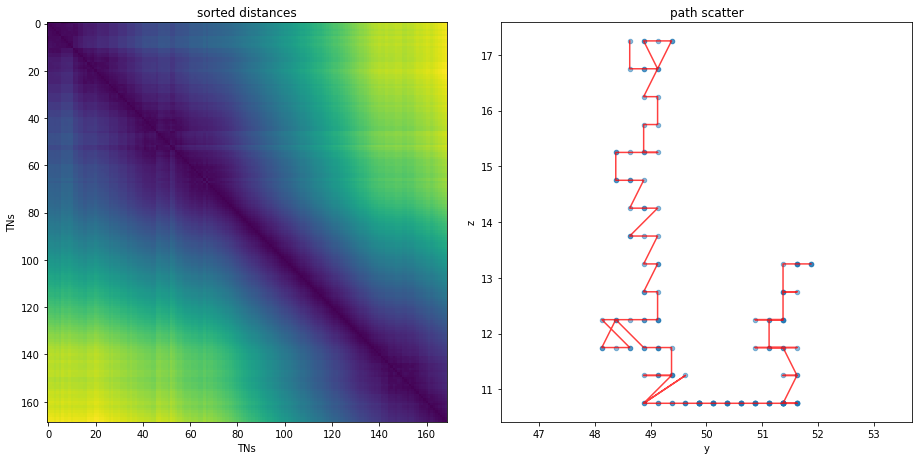

In [19]:
### A quick test of the TJ sorting

# FLAG: ROBUSTNESS -- Currently, ingore_path_check has to be set to True for this to work
#                     when z is properly rescaled (although the sort overall actually
#                     doesn't look too bad).

# Grab a TJ and compute the sort
TJCs = TNCs[TJs[list(TJs.keys())[0]]]
sorted_TJCs = sort_line_coords(TJCs, ignore_path_check=True)

# Get sorted pairwise distances
sorted_dists = spatial.distance.squareform(spatial.distance.pdist(sorted_TJCs))

# Plot pairwise distances
fig, ax = plt.subplots(1, 2, figsize=(13,6.5))
ax[0].imshow(sorted_dists)
ax[0].set_title("sorted distances")
ax[0].set_xlabel('TNs'); ax[0].set_ylabel('TNs')

# Plot path/tree on scatter
ax[1].scatter(TJCs[:,1], TJCs[:,0], s=20, alpha=0.5)
ax[1].plot(sorted_TJCs[:,1], sorted_TJCs[:,0], c='r', alpha=0.75)
ax[1].set_title("path scatter")
ax[1].set_xlabel('y'); ax[1].set_ylabel('z')

# Done
plt.axis('equal')
plt.tight_layout()
plt.show()

In [20]:
### Wrapper for spline fitting

def wrap_splprep(coords, k=3, verbose=False):
    """Fit an nD spline with scipy.interpolate.splprep.
    
    coords : array (points, dimensions) : input data
    k=3 : integer : degrees of freedom
    verbose=False : bool : wether to print all outputs
    
    returns -> tck : tuple (knots, coefficients, k) : 
               fit parameters as used by splev
    """
    
    # Fit the spline and unpack the (weirdly packaged) results
    tcku, fp, ier, msg = interpolate.splprep(coords.T, k=k, full_output=True)
    tck, u = tcku

    # Report the results
    if verbose:
        print ('\nt (knots, tck[0]):\n' , tck[0])
        print ('\nc (coefficients, tck[1]):\n' , tck[1])
        print ('\nk (degree, tck[2]):' , tck[2])
        print ('\nu (evaluation points):\n', u)
        print ('\nfp (residual error):', fp)
        print ('\nier (error code; success is ier<=0):', ier)
        print ('\nmsg (message from FITPACK):\n', msg)
        
    # Raise an error if FITPACK indicates failure
    if ier > 0:
        raise Exception('ier is >0, indicating that FITPACK failed somehow. '+
                        'The message from FITPACK was:\n'+msg)
        
    # Return the only result relevant to spline evaluation
    return tck

In [21]:
### Perform sorting and spline fitting on all TJs

# FLAG -- PRECISION: Currently, cases where the TNs of a single TJ_ID do not form a single
#                    continuous line are caught and those TJs are removed entirely (see
#                    InvalidGraphError handling). However, such cases can naturally occur
#                    in some (rare-ish) geometries involving 4+ cells and the background.
#                    Would be nice to somehow recognize these cases and handle them better,
#                    though the way the TJ_IDs are currently done wouldn't readily allow
#                    such a solution...

# Parameters
num_ts = 20     # Determines the number of TNs that will be analyzed throughout the rest of the pipeline
tng_dv = 10e-2  # FLAG -- PRECISION: Should this be smaller? FLAG -- ROBUSTNESS: Should this scale with res?

# Output dicts
TJs_spline_tck     = {}  # Fitted splines for each TJ
TJs_spline_t       = {}  # Parameter (t) values for evaluation
TJs_spline_ev      = {}  # Evaluated splines (at each t) for each TJ
TJs_spline_tangent = {}  # Tangents to splines for each TJ

# For each TJ...
for TJ_ID in TJs.keys():
    
    # Sort coordinates along the line
    try:
        sorted_TJCs, TJ_argsort = sort_line_coords(TNCs[TJs[TJ_ID]],
                                                   return_argsort=True,
                                                   ignore_path_check=True)
    except InvalidGraphError:  # Remove cases where points with the same TJ...
        del TJs[TJ_ID]         # ...identifier don't form a continuous line.
        continue
    TJs[TJ_ID] = TJs[TJ_ID][TJ_argsort]
    
    # Perform spline fitting
    tck = wrap_splprep(sorted_TJCs)
    TJs_spline_tck[TJ_ID] = tck
    
    # Evaluate the spline in 1000 regular intervals
    TJs_spline_t[TJ_ID] = np.linspace(0.0, 1.0, num_ts)
    ev = interpolate.splev(TJs_spline_t[TJ_ID], tck)
    ev = np.array(ev).T
    TJs_spline_ev[TJ_ID] = ev
    
    # Also evaluate with slight deviation forward and backward
    evD1 = np.array(interpolate.splev(TJs_spline_t[TJ_ID]+tng_dv, tck)).T
    evD2 = np.array(interpolate.splev(TJs_spline_t[TJ_ID]-tng_dv, tck)).T
    
    # Approximate the tangent vector as the sum of the deviatory vectors
    tangent_vec = ((evD1 - ev) + (ev - evD2)) / 2.0
    TJs_spline_tangent[TJ_ID] = tangent_vec

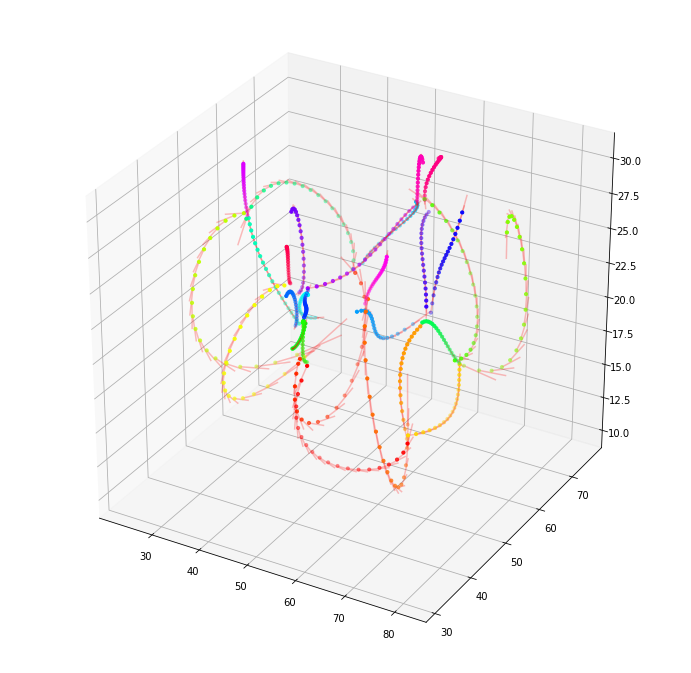

In [22]:
### Visualize the fitted splines and the tangent vectors as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

## Plot each TJ in a different color
#for TJ_num,TJ_ID in enumerate(TJs.keys()):
#    ax.scatter(TNCs[TJs[TJ_ID]][:,2], TNCs[TJs[TJ_ID]][:,1], TNCs[TJs[TJ_ID]][:,0],
#               c=[TJ_num for _ in range(TJs[TJ_ID].shape[0])], 
#               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

# Plot each TJ spline
for TJ_num,TJ_ID in enumerate(TJs_spline_ev.keys()):
    ax.scatter(TJs_spline_ev[TJ_ID][:,2], 
               TJs_spline_ev[TJ_ID][:,1], 
               TJs_spline_ev[TJ_ID][:,0],
               c=[TJ_num for _ in range(TJs_spline_ev[TJ_ID].shape[0])],
               cmap='hsv', vmin=0, vmax=len(TJs_spline_ev), s=10)

# Add the tangent vectors
for TJ_num, TJ_ID in enumerate(TJs_spline_ev.keys()):
    for splpt, tngvec in zip(TJs_spline_ev[TJ_ID], TJs_spline_tangent[TJ_ID]):
        plt.plot([splpt[2], splpt[2]+tngvec[2]],
                 [splpt[1], splpt[1]+tngvec[1]],
                 [splpt[0], splpt[0]+tngvec[0]],
                 'r-', alpha=0.25)
            
## Axis limits
#ax.set_xlim([0,200])
#ax.set_ylim([0,200])
#ax.set_zlim([0,200])

# Finish
plt.show()

### Projecting DNs onto TJ-Orthogonal Dihedral Planes

In [23]:
### Sympy function to project close-by outline points onto a TN's TJ-orthogonal plane

# FLAG: PERFORMANCE -- Save the resulting numpy func so that the symbolic solving doesn't need 
#                      to be rerun each time the code is executed! This is probably best done
#                      by copying the function out into a .py file and importing it from there.
#                      In the process, axis keywords could perhaps be added to handle vectorized
#                      execution across many points/planes (see issue flag below).
# FLAG: ROBUSTNESS -- Simply doing Gram-Schmidt as we currently do does not preserve the
#                     uv-coordinate system within the plane across multiple TNs of a TJ. 
#                     Under certain circumstances (when values of the normal vector cross
#                     zero), this can even lead to sudden 'flipping' of the orientation of
#                     the plane. Currently, this is implicitly being "fixed" downstream 
#                     since the vector triplets are being aligned by rotation and flipping
#                     prior to their reduction to a consensus triplet. However, it might be
#                     more clean and robust to do something slightly more sophisticated than
#                     classical Gram-Schmidt in order to enforce consistency.

# Import sympy symbols
from sympy.abc import q,r,s,  x,y,z  # (normal vector), (point to be projected)

# Use Gram-Schmidt orthogonalization to create orthonormal vectors defining the in-plane
# coordinate system given three arbitrary vectors, the first of which is the normal vector
# of the plane. The other two (defining the in-plane directionalities) are arbitrarily 
# chosen such that they will never fall onto the normal vector or onto each other.
orthonormals = sym.GramSchmidt([sym.Matrix([q,         r,         s]),  # Normal vec to plane -> first coordinate vec
                                sym.Matrix([q, 2*(r+0.1), 3*(s+0.1)]),  # Arbitrary vec not on the normal vec
                                sym.Matrix([2*(q+0.1), 3*(r+0.1), s])], # Arbitrary vec not on either other vec
                                orthonormal=True)           # Normalize resulting orthogonal vectors

# With the resulting orthonormals defining the new coordinate system, the projection
# of points into it is just a straightforward dot product.
projection_pt = sym.Matrix([x, y, z])
proj_d = orthonormals[0].dot(projection_pt)  # Distance from plane
proj_u = orthonormals[1].dot(projection_pt)  # Coordinate along first axis in plane
proj_v = orthonormals[2].dot(projection_pt)  # Coordinate along second axis in plane

# Lambdify
lambda_dist = sym.utilities.lambdify((q,r,s,x,y,z), proj_d, modules='numpy')
lambda_u    = sym.utilities.lambdify((q,r,s,x,y,z), proj_u, modules='numpy')
lambda_v    = sym.utilities.lambdify((q,r,s,x,y,z), proj_v, modules='numpy')

# Wrap into a function (sequential)
def p2p_projection(normal_vec, pt_coords):
        
    # Unpack inputs
    q,r,s = normal_vec[2], normal_vec[1], normal_vec[0]
    x,y,z = pt_coords[:,2], pt_coords[:,1], pt_coords[:,0]
    
    # Run projection
    dists = np.abs(lambda_dist(q,r,s,x,y,z))
    p_u   = lambda_u(q,r,s,x,y,z)
    p_v   = lambda_v(q,r,s,x,y,z)
    
    # Pack and return outputs
    projected = np.array([p_u, p_v]).T
    return projected, dists

## Wrap into a function (vectorized)
## FLAG -- ISSUE: This does not work as intended! It runs but does not yield the same results
##                as the sequential version. There is likely an missing `axis=` kwarg in one 
##                of the numpy functions substituted by lambdify. This could perhaps be fixed
##                by manual inspection of the projection function.
#def p2p_projection_vectorized(normal_vec, pt_coords):
#    
#    # Unpack inputs
#    q,r,s = normal_vec[..., 2, np.newaxis], normal_vec[..., 1, np.newaxis], normal_vec[..., 0, np.newaxis]
#    x,y,z = pt_coords[..., 2], pt_coords[..., 1], pt_coords[..., 0]
#    
#    # Run projection
#    dists = np.abs(lambda_dist(q,r,s,x,y,z))
#    p_u   = lambda_u(q,r,s,x,y,z)
#    p_v   = lambda_v(q,r,s,x,y,z)
#    
#    # Pack and return outputs
#    projected = np.rollaxis(np.array([p_u, p_v]), 2)
#    projected = np.rollaxis(projected, 2)
#    return projected, dists

In [24]:
### Project relevant DNs onto the TJ-orthogonal plane

# FLAG: PERFORMANCE -- This seems to scale very poorly! It takes a long time to run for
#                      a dataset that is just slightly bigger than the test data. Find
#                      ways of mitigating this, in particular by getting the vectorized
#                      version of p2p to work and maybe also by parallelization.

# Params
close_points_radius  = 25.0 * res[-1]
close_points_mindist = 10.0 * res[-1]
close_points_minnum  = 20
dist_points_keep     = 100

# Prep output dicts
TJs_DNs_proj = {}
TJs_DNs_dist = {}

# For each TJ...
for TJ_ID in TJs_spline_ev.keys():
    
    # Find the IDs of the three connected interfaces
    DJ_IDs = list(itertools.combinations(TJ_ID, 2))
    
    # Skip edge cases with more than 3
    if len(DJ_IDs) > 3:
        continue
        
    # Get corresponding TJ-normal vectors
    proj_tangents = TJs_spline_tangent[TJ_ID]
    
    # Prep output lists
    TJs_DNs_proj[TJ_ID] = {DJ_ID:[] for DJ_ID in DJ_IDs}
    TJs_DNs_dist[TJ_ID] = {DJ_ID:[] for DJ_ID in DJ_IDs}
    
    # For each TN of the current TJ...
    for TN_idx, TN in enumerate(TJs_spline_ev[TJ_ID]): 
        
        # For each connected interface...
        for DJ_idx, DJ_ID in enumerate(DJ_IDs):
            
            # Skip if interface has been removed
            if not DJ_ID in DJs:
                continue
            
            # Get all the DJ points of that interface
            current_DNCs = DNCs[DJs[DJ_ID]]
            
            # If there are none, skip this TN
            if current_DNCs.size == 0:
                print("Skipped case at TJ_ID="+str(TJ_ID) + ", TN_idx=" +str(TN_idx) + 
                      ", DJ_ID="+str(DJ_ID)+" ->> lacks interface points!")
                continue
                
            # Get the DN points close to the TN
            kdtree = spatial.cKDTree(current_DNCs)
            KNNs   = kdtree.query_ball_point(TN, close_points_radius)
            
            # If there are none, skip this TN
            if not KNNs:
                print("Skipped case at TJ_ID="+str(TJ_ID) + ", TN_idx=" +str(TN_idx) + 
                      ", DJ_ID="+str(DJ_ID)+" ->> no close-by neighbors!")
                continue
                
            # If there are very few, skip this TN
            if len(KNNs) < close_points_minnum:
                print("Skipped case at TJ_ID="+str(TJ_ID) + ", TN_idx=" +str(TN_idx) + 
                      ", DJ_ID="+str(DJ_ID)+" ->> not enough close-by neighbors!")
                continue
            
            # If they are all bunched up in a small space, skip this TN
            furthest_NN_dist = np.sqrt(np.max(np.sum((current_DNCs[KNNs] - TN)**2.0, axis=1)))
            if furthest_NN_dist < close_points_mindist:
                print("Skipped case at TJ_ID="+str(TJ_ID) + ", TN_idx=" +str(TN_idx) + 
                      ", DJ_ID="+str(DJ_ID)+" ->> only a small cluster of neighbors!")
                continue
            
            # Move the points onto the origin
            current_DNCs = current_DNCs[KNNs] - TJs_spline_ev[TJ_ID][TN_idx]
            
            # Nothing *should* go wrong here - but if it does, first look into
            # the way the arbitrary vectors for Gram-Schmidt are generated!
            with np.errstate(divide='raise', invalid='raise'):
                    
                # Project the TN points onto the dihedral plane
                projs, dists = p2p_projection(proj_tangents[TN_idx], current_DNCs)
            
            # Threshold on the distances; keep at most the closest n points
            psort = np.argsort(dists)[:dist_points_keep]
            projs = projs[psort]
            dists = dists[psort]
            
            # Keep the results
            TJs_DNs_proj[TJ_ID][DJ_ID].append(projs)
            TJs_DNs_dist[TJ_ID][DJ_ID].append(dists)

In [25]:
### Visualize the projections

@interact(TJ_ID=list(TJs_DNs_proj.keys()),
          TN_idx=(0,num_ts-1,1))
def plot_proj(TJ_ID=list(TJs_DNs_proj.keys())[0],
              TN_idx=num_ts//2):
    
    # Prep plot
    plt.figure(figsize=(6,6))
    
    # For each adjacent DJ...
    for DJ_ID in itertools.combinations(TJ_ID, 2):
        
        # Skip if interface has been removed
        if not DJ_ID in DJs:
            continue
        
        # Plot the projected points
        plt.scatter(TJs_DNs_proj[TJ_ID][DJ_ID][TN_idx][:,1],
                    TJs_DNs_proj[TJ_ID][DJ_ID][TN_idx][:,0],
                    c=TJs_DNs_dist[TJ_ID][DJ_ID][TN_idx],
                    cmap='viridis', alpha=0.5, lw=0)
    
    # Finish
    plt.xlabel('u')
    plt.ylabel('v')
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='TJ_ID', options=((0, 3, 4), (0, 2, 3), (0, 4, 5), (3, 4, 5), (0, 3…

### Retrieving Incident Vectors in the Dihedral Plane

**Note:** The arc fitting approach taken here is based on the second approach described in [this scipy cookbook entry](https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html). It could probably be further improved by using the third approach, i.e. by explicitly specifying the Jacobian function.

In [26]:
### Functions for circular arc fitting

# FLAG -- PERFORMANCE: The arc fitting approach used here could be sped up by explicitly
#                      specifying a Jacobian function, see the markdown note above.

# Compute coordinates from angle
def circle(r, cx, cy, alpha):
    x = r*np.cos(alpha) + cx
    y = r*np.sin(alpha) + cy
    return np.array([y,x])

# Compute radius/radii given a center and a point/multiple points
def radius(xc, yc, x, y):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

# Loss: distance of data points from mean circle
def circle_loss(c, x, y):
    radii = radius(c[0], c[1], x, y)
    return radii - radii.mean()

# Subtraction of n1 and n2, wrapping around at minimum and maximum
def wrap_sub(n1, n2, minimum=-np.pi, maximum=np.pi):
    s = n1 - n2 
    try:
        s[s<=minimum] = maximum + (s[s<=minimum] - minimum)
        s[s>=maximum] = minimum + (s[s>=maximum] - maximum)
    except TypeError:
        if s <= minimum: s = maximum + (s - minimum)
        if s >= maximum: s = minimum + (s - maximum)
    return s

# Wrapped median of an array of angles
# Note: The median of angles has to be computed on the unit vectors
#       to avoid getting into trouble with wrapping!
def wrap_median(angles, axis=None):
    unitvecs = circle(1.0, 0.0, 0.0, angles)
    median_vec = np.median(unitvecs, axis=axis+1 if axis is not None else None)
    median_ang = np.arctan2(median_vec[0], median_vec[1])
    return median_ang

In [27]:
### Find incident vectors for each TN based on circular arc fitting

# Prep output dict
TJs_vec_proj = {}

# For each TJ...
for TJ_ID in TJs_DNs_proj.keys():
    
    # Prepare an appropriate result array
    TJs_vec_proj[TJ_ID] = np.empty((TJs_spline_ev[TJ_ID].shape[0], 3, 2))  # Num. of TNs, 3 vectors, 2 dimensions
    TJs_vec_proj[TJ_ID].fill(np.nan)
    
    # For each adjacent DJ...
    for DJ_idx, DJ_ID in enumerate(list(itertools.combinations(TJ_ID, 2))):
        
        # Skip if interface has been removed
        if not DJ_ID in DJs:
            continue
        
        # For each TN along the TJ...
        for TN_idx in range(len(TJs_DNs_proj[TJ_ID][DJ_ID])):

            # Prep data for fitting
            #print(TJs_DNs_proj[TJ_ID][DJ_ID][TN_idx])
            x = TJs_DNs_proj[TJ_ID][DJ_ID][TN_idx][:,1]
            y = TJs_DNs_proj[TJ_ID][DJ_ID][TN_idx][:,0]
            
            # Fit a circle to the data
            center, ier = optimize.leastsq(circle_loss, [np.mean(x), np.mean(y)], args=(x, y))
            cx, cy = center
            r      = radius(cx, cy, x, y).mean()
            
            # Catch common fitting issue
            # If the diameter of the fitted circle is smaller than the distance between
            # TN and neighbor point furthest from it, the circle has likely been "inscribed"
            # rather than arc-fitted.
            is_inscribed = False
            if 2*r < furthest_NN_dist:
                is_inscribed = True
                print("Detected inscribed circle for TJ_ID="+str(TJ_ID) + ", TN_idx=" +str(TN_idx) + 
                      ", DJ_ID="+str(DJ_ID)+" ->> used TN to cloud centroid as vectors!")
            
            # Get angular position of the TN point (which is the origin in the projection)
            TN_alpha = np.arctan2(0.0-cy, 0.0-cx)

            # Get correct sign for tangent vector direction
            DNs_alpha = wrap_sub(np.arctan2(y-cy, x-cx), TN_alpha)
            sign = np.sign(np.mean(DNs_alpha))

            # Get tangent vector based on TN angle and small shift
            TN_proj = circle(r, cx, cy, TN_alpha)
            shifted = circle(r, cx, cy, TN_alpha+10e-5)
            tangent = shifted - TN_proj
            tangent = tangent * sign

            # Handle the common fitting issue by using a simple 'centroid vector' instead
            # FLAG -- PRECISION: It is very questionable whether this is better than simply
            #                    excluding the afflicted TNs! However, it may be the only 
            #                    way of making things work when exclusion would reduce the  
            #                    number of available TNs too far. Maybe provide as an option?
            if is_inscribed:
                tangent = np.array([np.mean(y)-TN[1], np.mean(x)-TN[2]])
                #continue  # DEV-TEMP!
            
            # Normalize to magnitude 1
            tangent = tangent / np.sqrt(np.sum(tangent**2.0))

            # Save the result
            TJs_vec_proj[TJ_ID][TN_idx, DJ_idx, :] = tangent

Detected inscribed circle for TJ_ID=(0, 3, 4), TN_idx=3, DJ_ID=(0, 3) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(0, 3, 4), TN_idx=15, DJ_ID=(0, 3) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(0, 2, 3), TN_idx=0, DJ_ID=(0, 2) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(0, 2, 3), TN_idx=1, DJ_ID=(0, 2) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(0, 2, 3), TN_idx=8, DJ_ID=(0, 2) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(0, 2, 3), TN_idx=0, DJ_ID=(0, 3) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 4, 5), TN_idx=15, DJ_ID=(3, 4) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 4, 5), TN_idx=16, DJ_ID=(3, 4) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 4, 5), TN_idx=17, DJ_ID=(3, 4) ->> used TN to cloud centroid 

Detected inscribed circle for TJ_ID=(3, 7, 8), TN_idx=13, DJ_ID=(7, 8) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 7, 8), TN_idx=18, DJ_ID=(7, 8) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 7, 8), TN_idx=19, DJ_ID=(7, 8) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(4, 7, 9), TN_idx=12, DJ_ID=(4, 9) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 7, 9), TN_idx=0, DJ_ID=(3, 7) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 7, 9), TN_idx=1, DJ_ID=(3, 7) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 7, 9), TN_idx=2, DJ_ID=(3, 7) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 7, 9), TN_idx=3, DJ_ID=(3, 7) ->> used TN to cloud centroid as vectors!
Detected inscribed circle for TJ_ID=(3, 7, 9), TN_idx=16, DJ_ID=(3, 7) ->> used TN to cloud centroid

In [28]:
### Remove TNs with a nan

# FLAG -- ROBUSTNESS: Removing nans here changes the number of TNs per TJ, which could cause
#                     a mess when other TJ-associated data is needed again later. Hence, the
#                     nan-afflicted TNs from all the relevant objects need to be removed,
#                     which is a bit of a pain and could lead to unexpected behavior...

# For each TJ...
for TJ_ID in list(TJs_vec_proj.keys()):
    
    # Find TNs with nans
    nan_mask = np.any( np.isnan(TJs_vec_proj[TJ_ID]), axis=(-1, -2) )
    
    # Reassign without those TNs
    TJs_vec_proj[TJ_ID] = TJs_vec_proj[TJ_ID][~nan_mask]
    
    # Report
    if nan_mask.sum() > 0:
        print("Removed", nan_mask.sum(), "TNs due to NaNs among vectors;", 
              (~nan_mask).sum(), "remain in TJ" + str(TJ_ID) + ".")
    
    # Remove TJs that now have too few TNs
    if np.sum(~nan_mask) < min_TNs:
        del TJs_vec_proj[TJ_ID]
        del TJs_DNs_proj[TJ_ID]
        print("Removed TJ", TJ_ID, "because it had less than the minimum number of TNs!")

# Report
print("\nNumber of TJs remaining:", len(TJs_vec_proj))


Number of TJs remaining: 28


In [29]:
### Visualize the projections

@interact(TJ_ID=list(TJs_DNs_proj.keys()),
          TN_idx=(0,num_ts-1,1))
def plot_proj(TJ_ID=list(TJs_DNs_proj.keys())[0],
              TN_idx=num_ts//2):
    
    # Prep plot
    plt.figure(figsize=(6,6))
    
    # For each adjacent DJ...
    for DJ_idx, DJ_ID in enumerate(list(itertools.combinations(TJ_ID, 2))):
        
        # Skip if interface has been removed
        if not DJ_ID in DJs:
            continue
        
        # Plot the projected points
        plt.scatter(TJs_DNs_proj[TJ_ID][DJ_ID][TN_idx][:,1],
                    TJs_DNs_proj[TJ_ID][DJ_ID][TN_idx][:,0],
                    c=TJs_DNs_dist[TJ_ID][DJ_ID][TN_idx],
                    cmap='viridis', alpha=0.5, lw=0)
        
        # Plot the fitted vectors
        plt.plot([0, TJs_vec_proj[TJ_ID][TN_idx, DJ_idx, 1]*10], 
                 [0, TJs_vec_proj[TJ_ID][TN_idx, DJ_idx, 0]*10],
                 c='k', lw='2', alpha=0.75)
    
    # Finish
    plt.xlabel('u')
    plt.ylabel('v')
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='TJ_ID', options=((0, 3, 4), (0, 2, 3), (0, 4, 5), (3, 4, 5), (0, 3…

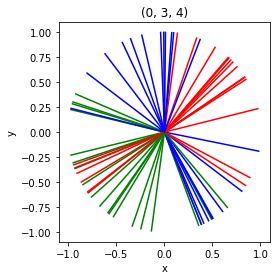

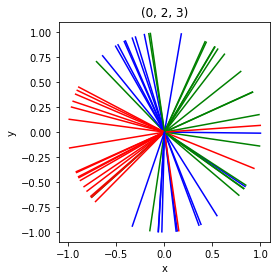

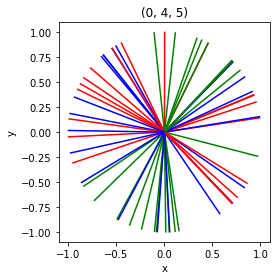

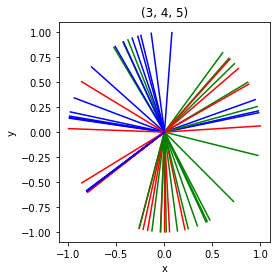

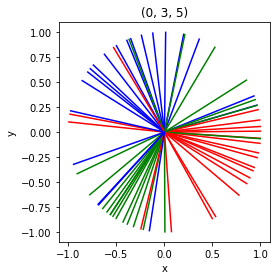

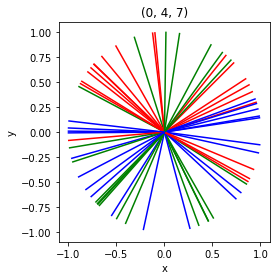

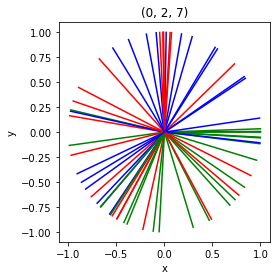

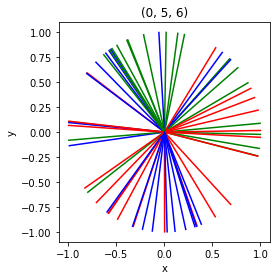

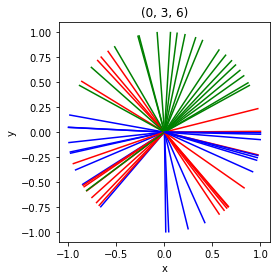

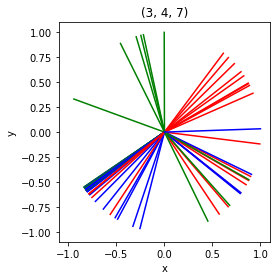

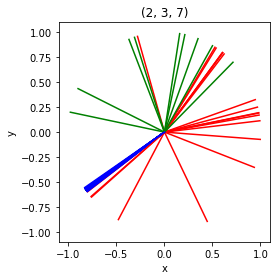

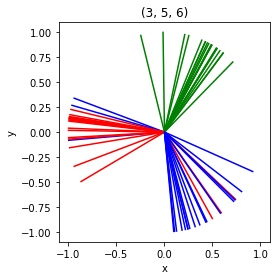

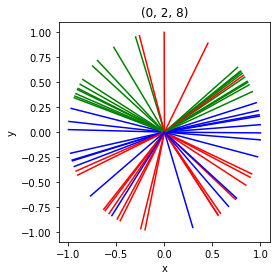

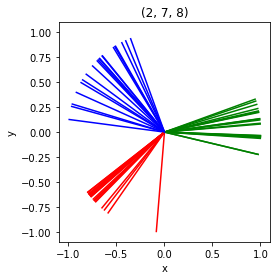

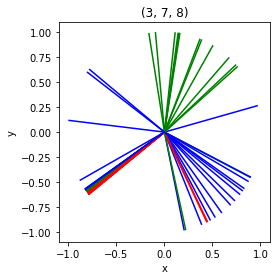

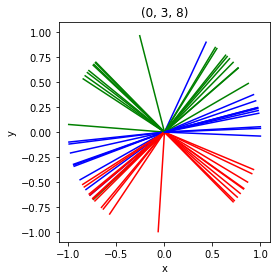

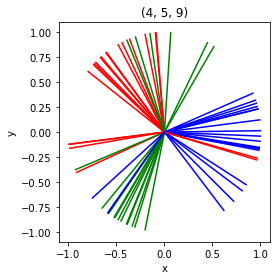

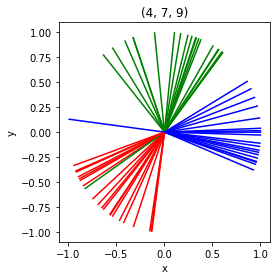

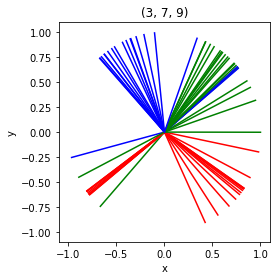

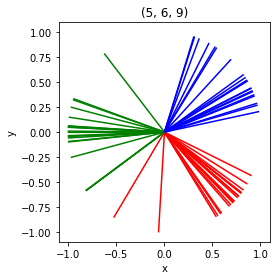

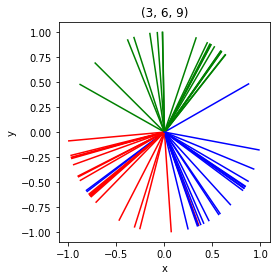

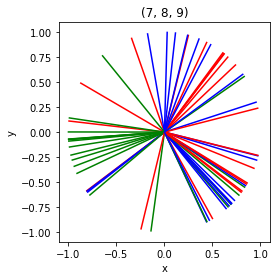

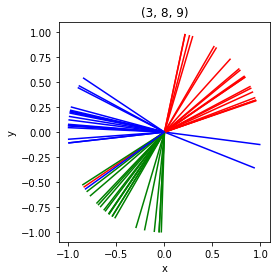

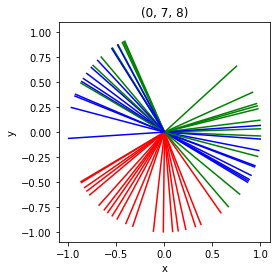

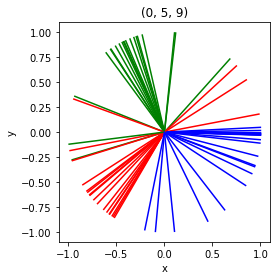

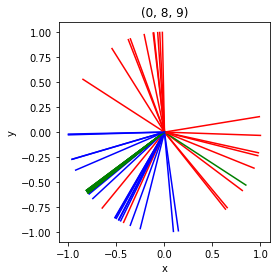

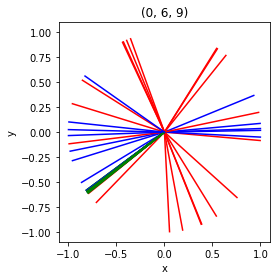

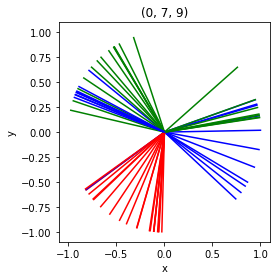

In [30]:
### Show the resulting vector triplets 

# FLAT: NOTE -- These are not aligned, which is okay but not ideal;
#               see ROBUSTNESS flag in sympy projection code.

# For each TJ...
cols = ['r','g','b']
for TJ_ID in TJs_vec_proj.keys():
    
    # Prep
    plt.figure(figsize=(4,4))
    
    # Plot each vec...
    for vec in TJs_vec_proj[TJ_ID]:
        for i,v in enumerate(vec):
            plt.plot([0,v[1]], [0,v[0]], c=cols[i])
            
    # Finalize
    plt.title(str(TJ_ID))
    plt.xlabel('x'); plt.ylabel('y')
    plt.xlim([-1.1, 1.1])
    plt.ylim([-1.1, 1.1])
    plt.tight_layout()
    plt.show()

### Aligning Incident Vectors Along TJs

In [31]:
### Align triplets based on first vector & flip those that are the wrong way around

# For each TJ...
TJs_vec_aligned = {}
for TJ_ID in TJs_vec_proj.keys():
    
    # Prep output container
    triplets_aligned = np.empty_like(TJs_vec_proj[TJ_ID])
    
    ## Rotate each triplet to lay the first vector onto zero angle [sequential]
    #angles_zeroed = np.empty((TJs_vec_proj[TJ_ID].shape[0], 3))
    #for t,triplet in enumerate(TJs_vec_proj[TJ_ID]):
    #    angles_raw = np.arctan2(triplet[:,0], triplet[:,1])
    #    angles_zeroed[t] = wrap_sub(angles_raw, angles_raw[0])
     
    # Rotate each triplet to lay the first vector onto zero angle [vectorized]
    angles_raw = np.arctan2(TJs_vec_proj[TJ_ID][:,:,0], TJs_vec_proj[TJ_ID][:,:,1])
    angles_zeroed = wrap_sub(angles_raw, angles_raw[:, 0, np.newaxis])

    ## Function: if flipped is better than the consensus (here the median), then flip [sequential]
    #def flip_improvement(angles_zeroed):
    #    median_ang = wrap_median(angles_zeroed, axis=0)
    #    for t in range(len(angles_zeroed)):
    #        diff_original = np.abs(wrap_sub( angles_zeroed[t], median_ang)) 
    #        diff_flipped  = np.abs(wrap_sub(-angles_zeroed[t], median_ang))
    #        if np.sum(diff_flipped) < np.sum(diff_original):
    #            angles_zeroed[t] = - angles_zeroed[t]
    #    return angles_zeroed
    
    # Function: if flipped is better than the consensus (here the median), then flip [vectorized]
    def flip_improvement(angles_zeroed):
        median_ang = wrap_median(angles_zeroed, axis=0)
        diff_original = np.abs(wrap_sub( angles_zeroed, median_ang))
        diff_flipped  = np.abs(wrap_sub(-angles_zeroed, median_ang))
        flip_mask = np.sum(diff_flipped, axis=1) < np.sum(diff_original, axis=1)
        angles_zeroed[flip_mask] = -angles_zeroed[flip_mask]
        return angles_zeroed
    
    # Run flip improvement until there is either...
    # ...no change from one step to the next, or
    # ...no improvement since 5 steps ago
    median_ang = wrap_median(angles_zeroed, axis=0)
    losses  = [np.abs(wrap_sub(angles_zeroed, median_ang))]
    counter = 0
    while True:
        
        # Run a flip
        angles_zeroed_new = flip_improvement(angles_zeroed)
        
        # Break if it changed nothing
        if np.all(angles_zeroed==angles_zeroed_new):
            break
            
        # Otherwise, compute and keep the new loss
        median_ang = wrap_median(angles_zeroed_new, axis=0)
        losses.append(np.abs(wrap_sub(angles_zeroed_new, median_ang)))
        
        # Break if the new loss is worse or equal to the loss 5 steps ago
        if (counter >= 5) and losses[-1] >= losses[-6]:
            break
            
        # Update
        angles_zeroed = angles_zeroed_new
        counter += 1
    
    # Convert back to unit vectors
    for t in range(len(angles_zeroed)):
        triplets_aligned[t] = circle(1.0, 0.0, 0.0, angles_zeroed[t]).T
        
    # Store results
    TJs_vec_aligned[TJ_ID] = triplets_aligned

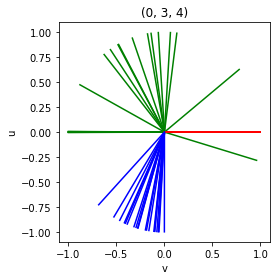

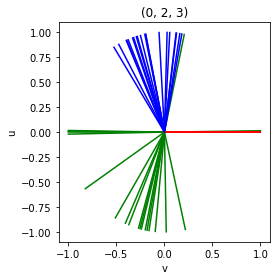

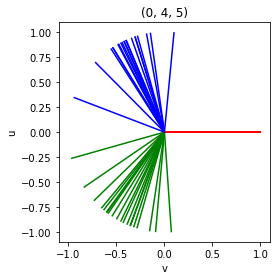

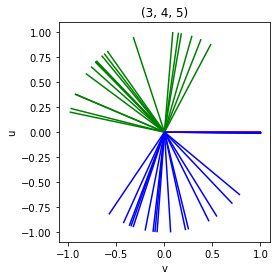

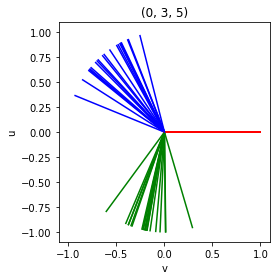

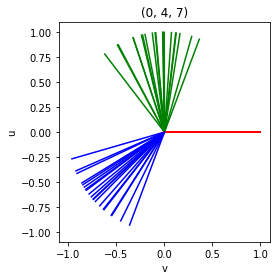

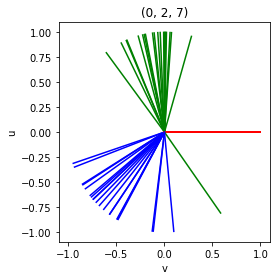

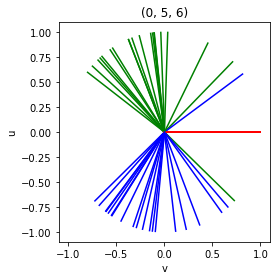

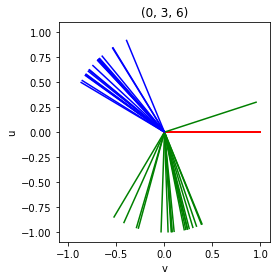

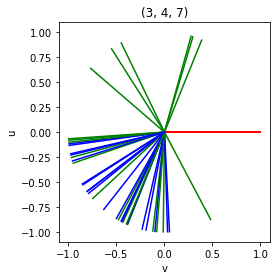

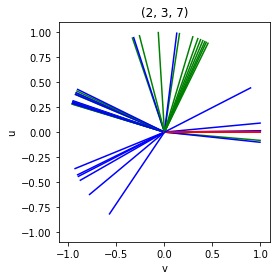

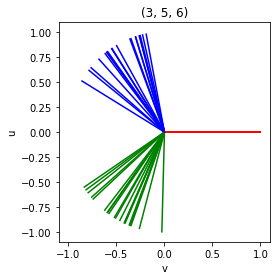

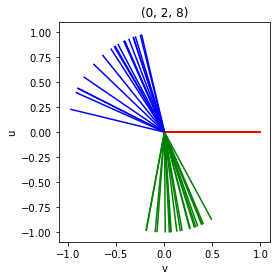

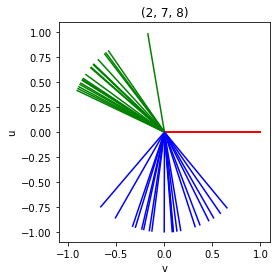

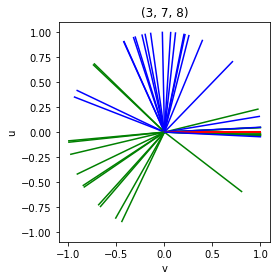

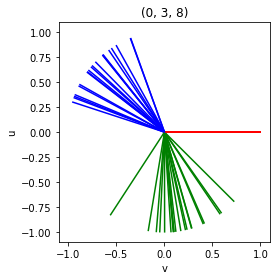

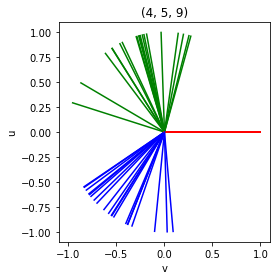

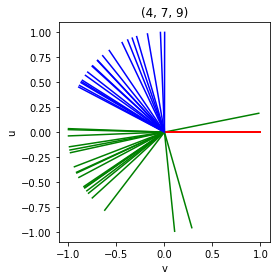

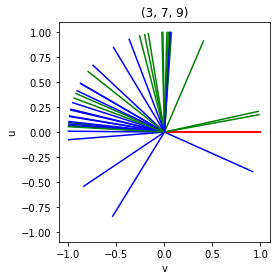

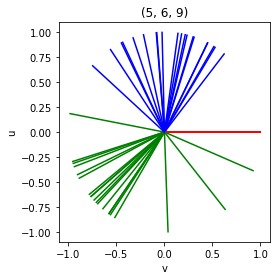

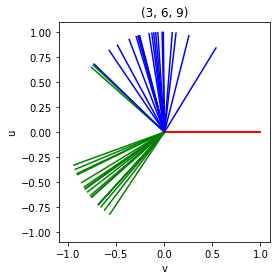

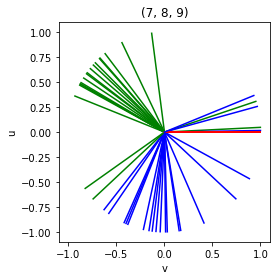

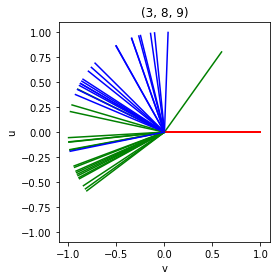

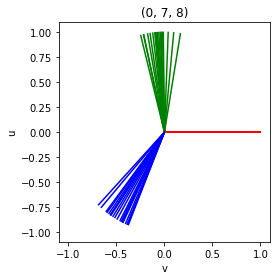

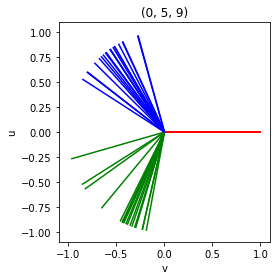

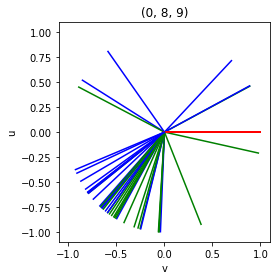

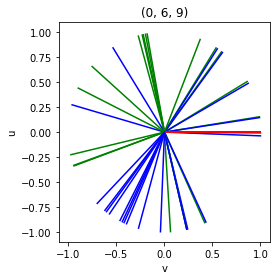

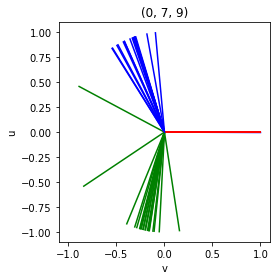

In [32]:
### Show the resulting aligned vector triplets 

# For each TJ...
cols = ['r','g','b']
for TJ_ID in TJs_vec_aligned.keys():
    
    # Prep
    plt.figure(figsize=(4,4))
    
    # Plot each vec...
    for vec in TJs_vec_aligned[TJ_ID]:
        for i,v in enumerate(vec):
            plt.plot([0,v[1]], [0,v[0]], c=cols[i])
            
    # Finalize
    plt.title(str(TJ_ID))
    plt.xlabel('v'); plt.ylabel('u')
    plt.xlim([-1.1, 1.1])
    plt.ylim([-1.1, 1.1])
    plt.tight_layout()
    plt.show()

### Finding Consensus Incident Vector Triplets

In [33]:
### Generate a consensus incident vector triplet for each TJ

# FLAG -- PRECISION, FLAG -- ROBUSTNESS: This is currently done in a very simple fashion.
#                                        It probably works fine / doesn't matter much for
#                                        data with a high z-resolution. However, there may
#                                        be room for improvement for low z-resolution data!

# For each TJ...
TJs_vec_consensus = {}
for TJ_ID in TJs_vec_aligned.keys():
    
    ## Compute the mean of vectors within the 25-75th percentile [OLD VERSION]
    ## Note: Whilst this seems more sophisticated than just using the median, the percentile 
    ##       masking as done here does not account for vector circle wrapping. Also, this 
    ##       implementation can have weird cases where for some vectors one of their dimensions 
    ##       is counted toward the consensus but not the other.
    #vecs_cons = np.empty((3,2))
    #loss_cons = np.empty(3)
    #p25, p75 = np.percentile(TJs_vec_aligned[TJ_ID], [25, 75], axis=0)
    #for v in range(3):
    #    vecs = TJs_vec_aligned[TJ_ID][:,v,:]
    #    mask = (vecs >= p25[v]) & (vecs <= p75[v])
    #    mean_v = np.mean(vecs[mask[:,0],0])
    #    mean_u = np.mean(vecs[mask[:,1],1])
    #    vecs_cons[v] = [mean_v, mean_u]
    
    # Compute the median of vectors [CURRENT VERSION]
    angs = np.arctan2(TJs_vec_aligned[TJ_ID][:,:,0], TJs_vec_aligned[TJ_ID][:,:,1])
    angs_consensus = wrap_median(angs, axis=0)
    vecs_consensus = circle(1.0, 0.0, 0.0, angs_consensus).T
    
    # Compute the 'loss' of the consensus & drop poor TJs
    # Note: The 'loss' is the mean deviation from the consensus. The threshold is chosen
    #       such that this mean deviation must not be greater than thresh_cons% of the
    #       unit circle.
    losses = np.sum(np.abs(wrap_sub(angs, angs_consensus)), axis=0) / angs.shape[0]
    if np.any(losses > 2.0*np.pi*(t_cons/100)):
        print("Removed TJ due to low consistency. TJ_ID:", TJ_ID)
        continue
    
    # YAH!
    # - Measure the "loss" of the resulting consensus and find an appropriate way of discarding 'bad' cases
    # + Consider re-including TNs that were excluded as 'stubs' in the arc fitting; they are now covered by the centroid fix
    # ~ Add in the excluding-DJs-if-no-information-in-G thingy!
    # ~ Port to VAL_Improved, as we may reach Brodland-like performance there (and that's good enough)
    # ~ Don't forget to see if you can have a go at the simulated data (which may be more clean...)
        
    # Renormalize
    TJs_vec_consensus[TJ_ID] = (vecs_consensus.T / np.sqrt(np.sum(vecs_consensus**2.0, axis=1))).T

Removed TJ due to low consistency. TJ_ID: (0, 3, 4)
Removed TJ due to low consistency. TJ_ID: (0, 2, 3)
Removed TJ due to low consistency. TJ_ID: (3, 4, 7)
Removed TJ due to low consistency. TJ_ID: (2, 3, 7)
Removed TJ due to low consistency. TJ_ID: (3, 7, 8)
Removed TJ due to low consistency. TJ_ID: (0, 8, 9)
Removed TJ due to low consistency. TJ_ID: (0, 6, 9)


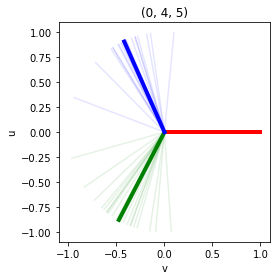

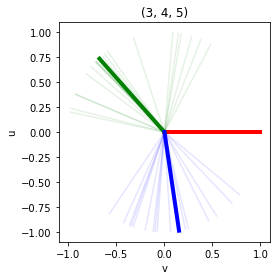

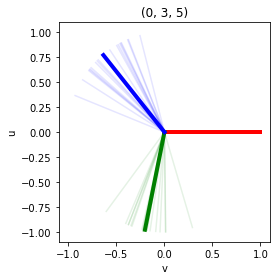

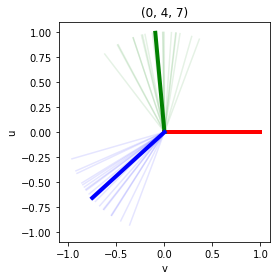

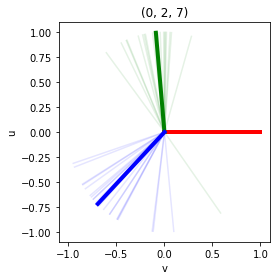

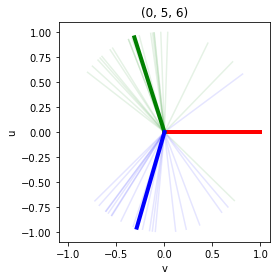

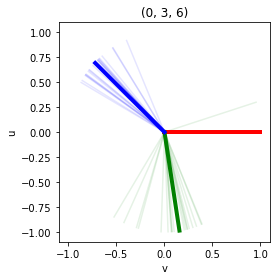

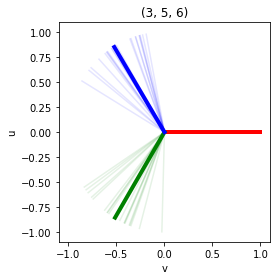

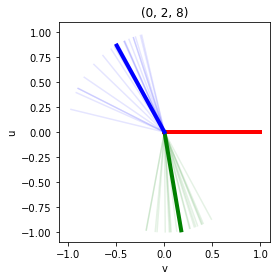

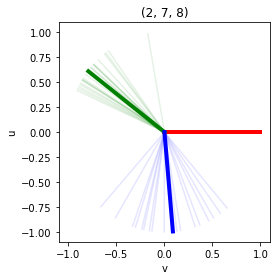

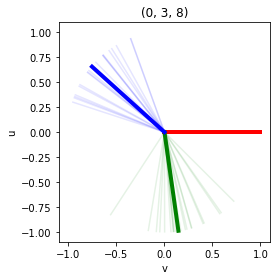

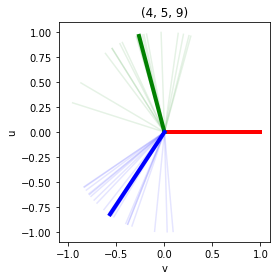

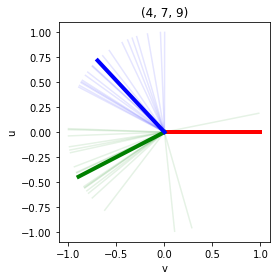

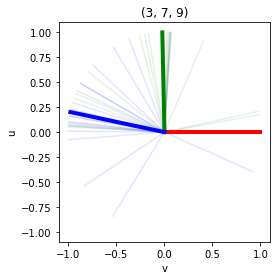

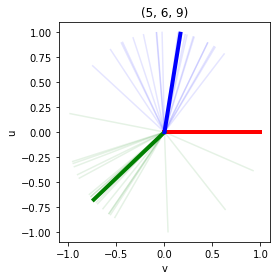

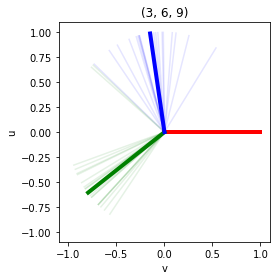

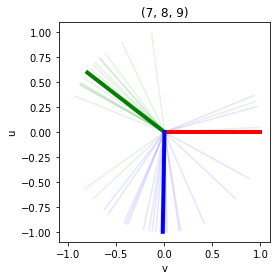

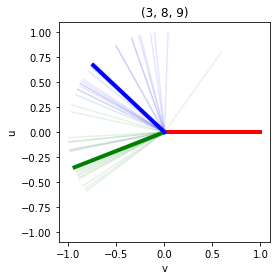

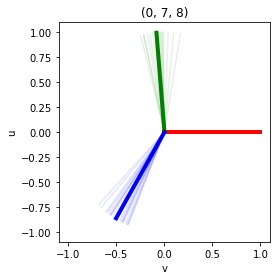

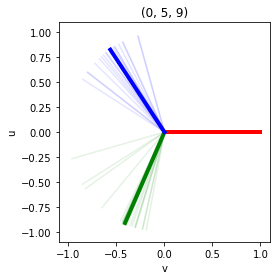

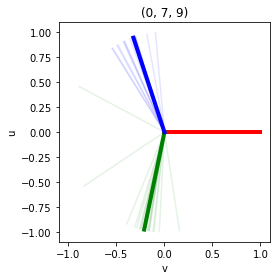

In [34]:
### Show the resulting consensus vector triplets 

# For each TJ...
cols = ['r','g','b']
for TJ_ID in TJs_vec_consensus.keys():
    
    # Prep
    plt.figure(figsize=(4,4))
    
    # Plot individual vecs...
    for vec in TJs_vec_aligned[TJ_ID]:
        for i,v in enumerate(vec):
            plt.plot([0,v[1]], [0,v[0]], c=cols[i], alpha=0.1)
            
    # Plot consensus vecs
    for i,v in enumerate(TJs_vec_consensus[TJ_ID]):
        plt.plot([0,v[1]], [0,v[0]], c=cols[i], lw=4)
            
    # Finalize
    plt.title(str(TJ_ID))
    plt.xlabel('v'); plt.ylabel('u')
    plt.xlim([-1.1, 1.1])
    plt.ylim([-1.1, 1.1])
    plt.tight_layout()
    plt.show()

### Solving the Force Balance Equations

#### Prep: Assembling Equation Matrix G

In [35]:
### Assemble G

# Initialize zero matrix of shape (2 * num of TJs, num of DJs)
G = np.zeros((2*len(TJs_vec_consensus), len(DJs)))

# For each TJ...
DJs_all_IDs = list(DJs.keys())
for TJ_idx, TJ_ID in enumerate(TJs_vec_consensus.keys()):
    
    # Get all relevant DJs
    DJ_IDs  = list(itertools.combinations(TJ_ID, 2))
    
    # For each DJ...
    for DJ_ref, DJ_ID in enumerate(DJ_IDs):
        
        # Skip if interface has been removed
        if not DJ_ID in DJs:
            continue
        
        # Get index (in G) of the current DJ
        DJ_idx = DJs_all_IDs.index(DJ_ID)

        # Fill the appropriate positions in G
        G[TJ_idx, DJ_idx] = TJs_vec_consensus[TJ_ID][DJ_ref][0]
        G[len(TJs_vec_consensus)+TJ_idx, DJ_idx] = TJs_vec_consensus[TJ_ID][DJ_ref][1]

(42, 26)


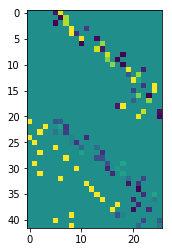

In [36]:
### Visualize the result
print(G.shape) # Should show G.shape[0] >= G.shape[1] (num of eqs >= num of interfaces)!
plt.imshow(G)
plt.show()

In [37]:
### Remove any DNs in G that do not have equations

# Find empty columns
mask = np.ones((G.shape[1]), dtype=np.bool)
for i in range(G.shape[1]):
    if np.sum(G[:,i]) == 0.0:
        print("Found empty column in G with index", i, "and DJ_ID", str(DJs_all_IDs[i])+"!")
        mask[i] = 0
        
# Remove empty columns
G = G[:,mask]

# Remove corresponding DJs from relevant linked objects
DJs_all_IDs = [DJs_all_IDs[i] for i in range(len(DJs_all_IDs)) if mask[i]]
for DJ_ID in list(DJs.keys()):
    if DJ_ID not in DJs_all_IDs: 
        del DJs[DJ_ID]

# Report
print('\n', G.shape, len(DJs_all_IDs), len(DJs))

Found empty column in G with index 4 and DJ_ID (2, 3)!

 (42, 25) 25 25


#### Solve using the `contraints` kwarg of scipy's minimize

In [38]:
### Define loss and constraints

# Loss: sum of square deviations of equilibrium equations
def eq_loss_c(gammas, G):
    loss = (np.dot(G, gammas))**2.0
    return np.sum(loss)

# Constraint: the mean of tensions must be 1
def eq_constraint(gammas):
    c = np.mean(gammas) - 1
    return c

In [39]:
### Run the fit
fit = optimize.minimize(eq_loss_c, np.ones(len(DJs)), args=(G,), 
                        constraints={'type':'eq', 'fun':eq_constraint})
tensions_c = fit.x
print(tensions_c)

# FLAG -- ISSUE: The softest interface has a negative tension. I'm not sure
#                if that indicates a problem. It might be perfectly fine;
#                after all, the tensions are relative to the mean and they
#                are effective surface tensions, so high adhesion should
#                be able to make them net-negative. Furthermore, this
#                synthetic test sample has been constructed from geometric
#                objects, so it doesn't represent a realistic structure.

# Keep results
DJs_tensions_c = {DJ_ID:tensions_c[DJ_num] for DJ_num, DJ_ID in enumerate(DJs_all_IDs)}

[1.06955437 0.71239662 0.81607256 0.73363614 0.95393397 0.98760426
 1.19070227 0.7393307  1.06069592 0.95184013 1.49550096 1.08825063
 1.01068711 1.03769001 1.45510171 1.28240447 1.0018158  1.01986129
 1.08308956 0.63883327 1.01705557 1.23579102 0.67357039 0.67400963
 1.07057165]


In [40]:
### Show tensions on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray', vmin=outlines_id.min(), vmax=outlines_id.max())
    
    # For each DJ...
    for DJ_num, DJ_ID in enumerate(DJs.keys()):
        
        # Get the DJ's DNs in the selected z plane
        DNs_in_plane = DNIs[DJs[DJ_ID]][DNIs[DJs[DJ_ID]][:,0]==z]
        
        # Plot the points
        plt.scatter(DNs_in_plane[:, 2], DNs_in_plane[:, 1],
                    c=[tensions_c[DJ_num] for _ in range(DNs_in_plane.shape[0])],
                    vmin=np.min(tensions_c), vmax=np.max(tensions_c),
                    cmap='viridis', s=20)
    
    # Finish
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=29, description='z', max=58), Output()), _dom_classes=('widget-interact'…

#### Solve using Brodland et alii's Lagrange Multiplier Approach

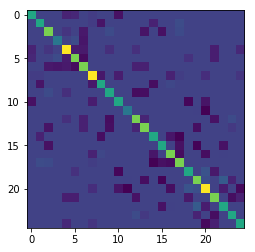

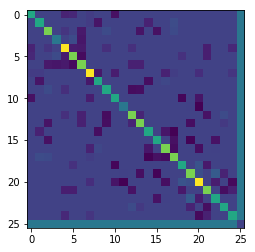

In [41]:
### Prepare the matrix

# Gdot
Gdot = np.dot(G.T, G)

# Show
plt.imshow(Gdot)
plt.show()

# Add the constraints
Gready = np.zeros((Gdot.shape[0]+1, Gdot.shape[1]+1))
Gready[:Gdot.shape[0], :Gdot.shape[1]] = Gdot
Gready[-1,:-1] = 1.0
Gready[:-1,-1] = 1.0

# Show
plt.imshow(Gready)
plt.show()

In [42]:
### Define loss

# Loss combining tension fit and constraint
def eq_loss_l(gammas_lagrange, Gready):
    loss = np.sum(np.dot(Gready[:-1], gammas_lagrange)**2.0)  # Fit loss
    loss += (np.dot(Gready[-1], gammas_lagrange) - (gammas_lagrange.size-1))**2.0  # Constraint loss    
    return loss

In [43]:
### Run the fit
fit = optimize.minimize(eq_loss_l, np.ones(len(DJs)+1), args=(Gready,))
tensions_l = fit.x[:-1]
lagrange = fit.x[-1]
print(tensions_l)
print(lagrange)

# FLAG -- ISSUE: Negative tension value, same as above with the scipy-based
#                approach. See flag there for more info.

# Keep results
DJs_tensions_l = {DJ_ID:tensions_l[DJ_num] for DJ_num, DJ_ID in enumerate(DJs_all_IDs)}

[1.06953532 0.71258968 0.81597755 0.73374193 0.95387368 0.98759838
 1.19072794 0.73939643 1.06087627 0.9519457  1.49548193 1.0880772
 1.01076894 1.03770269 1.4552319  1.28223331 1.00180501 1.01986795
 1.08308712 0.6387753  1.01698407 1.23576527 0.67340545 0.67395737
 1.07059354]
-0.07756731387092158


In [44]:
### Show tensions on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray', vmin=outlines_id.min(), vmax=outlines_id.max())
    
    # For each DJ...
    for DJ_num, DJ_ID in enumerate(DJs.keys()):
        
        # Get the DJ's DNs in the selected z plane
        DNs_in_plane = DNIs[DJs[DJ_ID]][DNIs[DJs[DJ_ID]][:,0]==z]
        
        # Plot the points
        plt.scatter(DNs_in_plane[:, 2], DNs_in_plane[:, 1],
                    c=[tensions_l[DJ_num] for _ in range(DNs_in_plane.shape[0])],
                    vmin=np.min(tensions_l), vmax=np.max(tensions_l),
                    cmap='viridis', s=20)
    
    # Finish
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=29, description='z', max=58), Output()), _dom_classes=('widget-interact'…

#### Compare Solver vs Lagrange

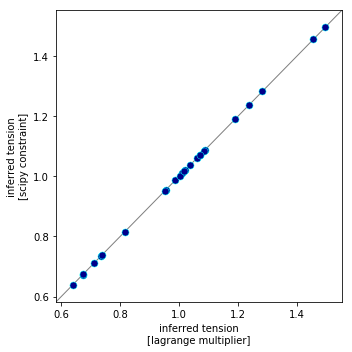

In [45]:
### Plot against each other

# Prep
plt.figure(figsize=(5,5))

# Plot
plt.scatter(tensions_l, tensions_c, s=50,
            c='darkblue', lw=0.5, edgecolor='cyan')

# Add equality line
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([-10,10], [-10,10], 'k-', zorder=-1, lw=1, alpha=0.5)
plt.xlim(xlims); plt.ylim(ylims)

# Labels
plt.xlabel("inferred tension\n[lagrange multiplier]")
plt.ylabel("inferred tension\n[scipy constraint]")

# Finalize
plt.tight_layout()
plt.show()

### Comparison with CellFIT3D and Microaspiration Data

In [46]:
### Load validation data

# Get Pandas
import pandas as pd

# Read
df_t4 = pd.read_csv(r'..\Data\Brodland\Brodland_20190726_clean\t000004\t000004_OUT.txt', delimiter='\t')
df_t9 = pd.read_csv(r'..\Data\Brodland\Brodland_20190726_clean\t000009\t000009_OUT.txt', delimiter='\t')

# Add color information
colors = {'a':'darkorange', 'b':'lightgray', 'c':'orange', 
          'd':'blue', 'e':'green', 'f':'darkblue', 
          'g':'brown', 'h':'gray'}
df_t4['colors'] = df_t4['Interface_abc'].map(colors)
df_t9['colors'] = df_t9['Interface_abc'].map(colors)

# Remove rows with NaNs
df_t4 = df_t4.dropna(axis=0)
df_t9 = df_t9.dropna(axis=0)

# Select the one to compare to
if 't000004' in fpath:
    df = df_t4
if 't000009' in fpath:
    df = df_t9

# Report
df.head()

,EdgeID,Interface_abc,Interface_tuple,CellFIT_raw,CellFIT_stdErr_raw,Pipette,CellFIT_rescaled,CellFIT_stdErr_rescaled,colors
0,3,a,"(0, 3)",0.742157,0.046797,204.1,240.668410,15.175441,darkorange
1,8,e,"(0, 8)",0.641384,0.041644,231.6,207.989505,13.504414,green
3,9,h,"(0, 9)",0.984790,0.055048,308.2,319.350007,17.851094,gray
5,4,d,"(0, 4)",0.886686,0.041506,304.7,287.536612,13.459663,blue
6,5,b,"(0, 5)",0.916088,0.039197,253.9,297.071162,12.710895,lightgray


In [47]:
### Add the pyCFI results to the dataframe

# First fix the interface tuples in the df (all non-zero values are off by one...)
for i, tup in enumerate(df['Interface_tuple']):
    tup0 = int(tup.split(',')[0][1:])
    tup1 = int(tup.split(',')[1][:-1])
    if tup1 > 0:
        tup1 -= 1
    df['Interface_tuple'].iat[i] = str((tup0, tup1))
    
# Create a small df of the tension data
df_tensions_c = pd.DataFrame(list(DJs_tensions_c.items()), columns=['Interface_tuple', 'pyCFI_c'])
df_tensions_l = pd.DataFrame(list(DJs_tensions_c.items()), columns=['Interface_tuple', 'pyCFI_l'])
df_tensions = pd.merge(df_tensions_c, df_tensions_l, on='Interface_tuple')
df_tensions['Interface_tuple'] = df_tensions['Interface_tuple'].astype(str)

# Add the tension data to the validation data
df = pd.merge(df, df_tensions, on='Interface_tuple')

# Add rescaled tension data
df['pyCFI_c_rescaled'] = df['pyCFI_c'] / df['pyCFI_c'].mean() * df['Pipette'].mean()
df['pyCFI_l_rescaled'] = df['pyCFI_l'] / df['pyCFI_l'].mean() * df['Pipette'].mean()

# Report
df.head()

,EdgeID,Interface_abc,Interface_tuple,CellFIT_raw,CellFIT_stdErr_raw,Pipette,CellFIT_rescaled,CellFIT_stdErr_rescaled,colors,pyCFI_c,pyCFI_l,pyCFI_c_rescaled,pyCFI_l_rescaled
0,3,a,"(0, 2)",0.742157,0.046797,204.1,240.668410,15.175441,darkorange,0.712397,0.712397,204.173001,204.173001
1,8,e,"(0, 7)",0.641384,0.041644,231.6,207.989505,13.504414,green,0.739331,0.739331,211.892313,211.892313
2,9,h,"(0, 8)",0.984790,0.055048,308.2,319.350007,17.851094,gray,1.019861,1.019861,292.292431,292.292431
3,4,d,"(0, 3)",0.886686,0.041506,304.7,287.536612,13.459663,blue,0.816073,0.816073,233.886543,233.886543
4,5,b,"(0, 4)",0.916088,0.039197,253.9,297.071162,12.710895,lightgray,1.069554,1.069554,306.534476,306.534476


pyCFI:   (0.5132917803749417, 0.193261723997201)
CellFIT: (0.648990198573339, 0.081653240579316)


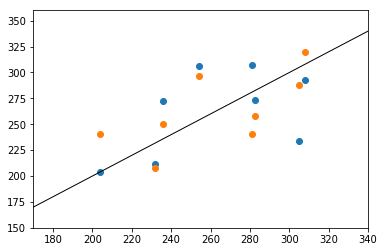

In [55]:
### Show result

# Some stats
from scipy.stats import pearsonr
print('pyCFI:  ', pearsonr(df['Pipette'], df['pyCFI_l_rescaled']))
print('CellFIT:', pearsonr(df['Pipette'], df['CellFIT_rescaled']))

# Plot data
plt.scatter(df['Pipette'], df['pyCFI_l_rescaled'])
plt.scatter(df['Pipette'], df['CellFIT_rescaled'])

# Perfect correlation line
plt.plot([0, 1000], [0, 1000], 'k-', 
         lw=1.0, zorder=1)

# Adjust axis limits
plt.xlim([170, 340])
plt.ylim([150, 360])

# Show
plt.show()